In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# 设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

context_path = '/kaggle/input/chinese-couplets/couplet/'
# context_path = 'week08/homework/couplet/'
for dirname, _, filenames in os.walk(context_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


def load_lines(filepath=context_path, filename='vocabs', rows=100000):
    # 读取文件，每行以空格分隔
    with open(f'{filepath}{filename}', 'r') as f:
        lines = []
        line = f.readline()
        while line and len(lines) < rows:
            words = line.strip().split(' ')
            lines.append(words)
            line = f.readline()
    print(filename, len(lines))
    return lines


BATCH_SIZE = 32
MAX_LENGTH = 500
ALL_DATA_SIZE = BATCH_SIZE * 50
TRAIN_DATA_SIZE = ALL_DATA_SIZE * 8 // 10
# 字典
all_tokens = ['_', '<s>', '</s>', 'UNK']
vocabs = {token: index for index, token in enumerate(all_tokens)}
PAD = vocabs['_']
BOS = vocabs['<s>']
EOS = vocabs['</s>']
UNK = vocabs['UNK']


def get_ind_or_set(x: str):
    if x in vocabs:
        return vocabs[x]
    else:
        new_index = len(all_tokens)
        all_tokens.append(x)
        vocabs[x] = new_index
        return new_index


x_data = load_lines(filename='train/in.txt', rows=ALL_DATA_SIZE)
y_data = load_lines(filename='train/out.txt', rows=ALL_DATA_SIZE)
all_data = [([get_ind_or_set(i) for i in x],
             [get_ind_or_set(i) for i in y])
            for x, y in zip(x_data, y_data)]
vocabs_sz = len(vocabs)
print('size of vocabs', vocabs_sz)


def collate(batch):
    enc_input = []
    dec_input = []
    dec_output = []
    for x, y in batch:
        enc_input.append(torch.tensor([BOS, *x, EOS], device=device))
        dec_input.append(torch.tensor([BOS, *y[:-1], EOS], device=device))
        dec_output.append(torch.tensor([*y, EOS], device=device))
    enc_input = torch.nn.utils.rnn.pad_sequence(
        enc_input, batch_first=True, padding_value=PAD)
    dec_input = torch.nn.utils.rnn.pad_sequence(
        dec_input, batch_first=True, padding_value=PAD)
    dec_output = torch.nn.utils.rnn.pad_sequence(
        dec_output, batch_first=True, padding_value=PAD)
    return enc_input, dec_input, dec_output


# 训练集
data = all_data[:TRAIN_DATA_SIZE]
dl = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)
# 测试集
test_data = all_data[TRAIN_DATA_SIZE:]
test_dl = DataLoader(test_data, shuffle=True, collate_fn=collate)

if __name__ == '__main__':
    i = 0
    for x, y, z in dl:
        print(x.shape, y.shape, z.shape)
        i += 1
        if i > 1:
            break


cuda
/kaggle/input/chinese-couplets/couplet/vocabs
/kaggle/input/chinese-couplets/couplet/test/out.txt
/kaggle/input/chinese-couplets/couplet/test/in.txt
/kaggle/input/chinese-couplets/couplet/test/.in.txt.swp
/kaggle/input/chinese-couplets/couplet/test/.out.txt.swp
/kaggle/input/chinese-couplets/couplet/train/out.txt
/kaggle/input/chinese-couplets/couplet/train/in.txt
train/in.txt 1600
train/out.txt 1600
size of vocabs 2870
torch.Size([32, 25]) torch.Size([32, 24]) torch.Size([32, 24])
torch.Size([32, 30]) torch.Size([32, 29]) torch.Size([32, 29])


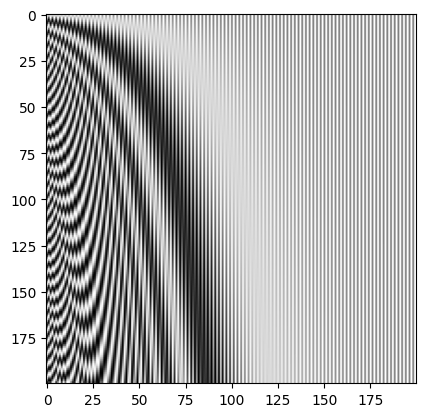

torch.Size([80, 100, 200])
torch.Size([80, 100, 200])


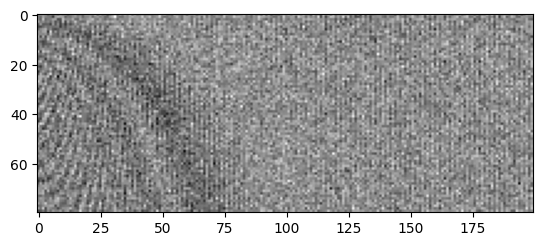

In [2]:
import math
import matplotlib.pyplot as plt


def get_pos_embedding(maxlen, embedding_size):
    theta = torch.exp(-torch.arange(0, embedding_size, 2)
                      * math.log(10000) / embedding_size)
    pos = torch.arange(0, maxlen).reshape(maxlen, 1)
    pos_embedding = torch.zeros((maxlen, embedding_size))
    pos_embedding[:, 0::2] = torch.sin(pos * theta)
    pos_embedding[:, 1::2] = torch.cos(pos * theta)
    plt.imshow(pos_embedding[:embedding_size], cmap='gray')
    plt.show()
    return pos_embedding


class PositionEncoding(nn.Module):
    def __init__(self, embedding_size, dropout, maxlen=1000):
        super().__init__()
        pos_embdding = get_pos_embedding(maxlen, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embdding.unsqueeze(1))

    def forward(self, token_embdding):
        seq_len = token_embdding.size(0)  # token长度
        token_embdding = token_embdding + self.pos_embedding[:seq_len, :]
        return self.dropout(token_embdding)


embedding_size = 200
num_embedding = 1000
batch_size = 100
seq_len = 80
ps = PositionEncoding(embedding_size, 0)
test_emb = nn.Embedding(num_embedding, embedding_size)
test_input = torch.randint(0, num_embedding, (seq_len, batch_size))
out: torch.Tensor = test_emb(test_input)
print(out.shape)
out = ps(out)
print(out.shape)
plt.imshow(out[:, 0].detach().numpy(), cmap='gray')
plt.show()


In [3]:

def mask_fill(mt):
    return mt.masked_fill(mt == 1, float(0.)).masked_fill(mt == 0, float('-inf'))

def create_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

    

sz = 4
mt = torch.ones((sz, sz))
print(mt)
print(mask_fill(mt.triu()))
mt = mask_fill(mt.tril())
print(torch.softmax(mt, dim=0))
print(mt)
print(create_mask(3))
torch.softmax(mt+torch.randn((sz, sz)), dim=0)


tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[0., 0., 0., 0.],
        [-inf, 0., 0., 0.],
        [-inf, -inf, 0., 0.],
        [-inf, -inf, -inf, 0.]])
tensor([[0.2500, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.3333, 0.0000, 0.0000],
        [0.2500, 0.3333, 0.5000, 0.0000],
        [0.2500, 0.3333, 0.5000, 1.0000]])
tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])
tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]], device='cuda:0')


tensor([[0.1537, 0.0000, 0.0000, 0.0000],
        [0.2899, 0.3691, 0.0000, 0.0000],
        [0.1191, 0.4138, 0.2334, 0.0000],
        [0.4373, 0.2171, 0.7666, 1.0000]])

In [4]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_enc_layers, num_dec_layers, dim_forward, dropout, enc_voc_size,dec_voc_size):
        super().__init__()
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_enc_layers, num_decoder_layers=num_dec_layers,
                                          dim_feedforward=dim_forward, dropout=dropout, batch_first=True)
        self.enc_emb = nn.Embedding(enc_voc_size, d_model)
        self.dec_emb = nn.Embedding(dec_voc_size, d_model)
        self.ff = nn.Linear(d_model, dec_voc_size)
        self.pos_encoding = PositionEncoding(d_model, dropout)
        self.d_model = d_model
        
    def forward(self, enc_input, dec_input, tgt_mask, enc_pad_mask, dec_pad_mask):
        enc_emb = self.encode_embedding(enc_input)
        dec_emb = self.decode_embedding(dec_input)
        outs = self.transformer(src=enc_emb, tgt=dec_emb, tgt_mask=tgt_mask,
                         src_key_padding_mask=enc_pad_mask, 
                         tgt_key_padding_mask=dec_pad_mask)
        return self.ff(outs)
    
    def encode(self, enc_input):
        enc_emb = self.encode_embedding(enc_input)
        return self.transformer.encoder(enc_emb)
    
    def decode(self, dec_input, memory, dec_mask):
        dec_emb = self.decode_embedding(dec_input)
        out = self.transformer.decoder(dec_emb, memory, dec_mask)
        return self.ff(out)
    
    def encode_embedding(self, input):
        return self.pos_encoding(self.enc_emb(input))
        
    def decode_embedding(self, input):
        return self.pos_encoding(self.dec_emb(input))


In [5]:
import random
import time

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
    
def train_epoch(dataloader, model, optimizer, criterion):
    total_loss = 0
    for input_tensor, tgt_input, tgt_output in dataloader:
        optimizer.zero_grad()
        tgt_mask = create_mask(tgt_input.size(1))
        src_pad_mask = (input_tensor==0)
        tgt_pad_mask = (tgt_input==0)
        out = model(input_tensor, tgt_input, tgt_mask, src_pad_mask, tgt_pad_mask)
        # print(input_tensor.shape, target_tensor.shape, tgt_input.shape, out.shape)
        # print(out)
        # out += 1
        loss = criterion(
            out.reshape(-1, out.size(-1)),
            tgt_output.reshape(-1)
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [6]:
def train(train_dataloader, model, n_epochs, learning_rate=0.0001,
               print_every=20, plot_every=5):
    start = time.time()
    plot_epoches = []
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, model, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            plot_epoches.append(epoch)
            
    plt.scatter(plot_epoches, plot_losses)
    plt.show()

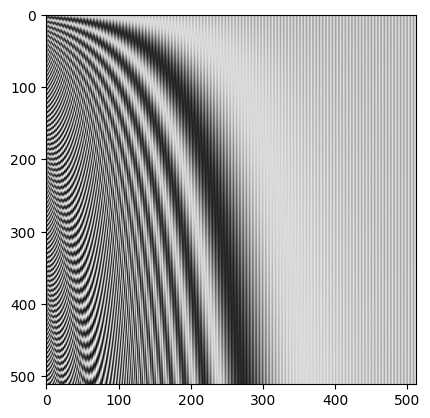

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


0m 26s (- 10m 42s) (20 4%) 2.4981
0m 48s (- 9m 17s) (40 8%) 1.2029
1m 10s (- 8m 33s) (60 12%) 0.3273
1m 31s (- 8m 1s) (80 16%) 0.0860
1m 53s (- 7m 33s) (100 20%) 0.0404
2m 15s (- 7m 7s) (120 24%) 0.0248
2m 36s (- 6m 42s) (140 28%) 0.0187
2m 58s (- 6m 18s) (160 32%) 0.0151
3m 19s (- 5m 55s) (180 36%) 0.0128
3m 41s (- 5m 32s) (200 40%) 0.0113
4m 3s (- 5m 9s) (220 44%) 0.0102
4m 24s (- 4m 46s) (240 48%) 0.0095
4m 46s (- 4m 24s) (260 52%) 0.0092
5m 8s (- 4m 2s) (280 56%) 0.0082
5m 29s (- 3m 39s) (300 60%) 0.0071
5m 51s (- 3m 17s) (320 64%) 0.0070
6m 13s (- 2m 55s) (340 68%) 0.0069
6m 34s (- 2m 33s) (360 72%) 0.0056
6m 56s (- 2m 11s) (380 76%) 0.0063
7m 18s (- 1m 49s) (400 80%) 0.0055
7m 40s (- 1m 27s) (420 84%) 0.0053
8m 2s (- 1m 5s) (440 88%) 0.0051
8m 24s (- 0m 43s) (460 92%) 0.0049
8m 46s (- 0m 21s) (480 96%) 0.0042
9m 7s (- 0m 0s) (500 100%) 0.0050


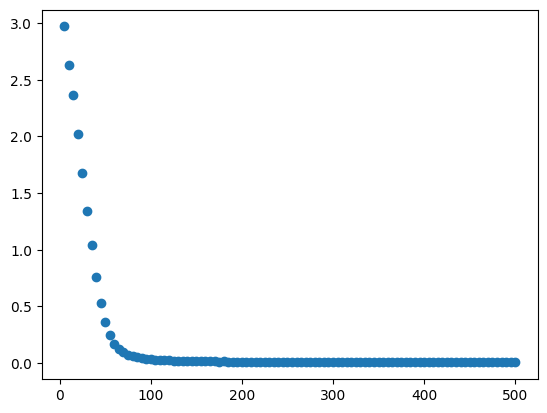

In [7]:
model = Seq2SeqTransformer(512, 8, 3, 3, 512, 0.1, len(all_tokens), len(all_tokens)).to(device=device)
train(dl, model, 500)
torch.save(model.state_dict(), "model.weights")

In [8]:
def greedy_decode(model, src, start_symbol, end_symbol):
    src = src.to(device)
    batch_sz, seq_len = src.shape
    memory = model.encode(src)
    # print('src', src.shape)
    ys = torch.ones(batch_sz, 1).fill_(start_symbol).type(torch.long).to(device)
    # print(seq_len)
    for i in range(seq_len + 3):
        memory = memory.to(device)
        tgt_mask = create_mask(ys.size(1))
        out = model.decode(ys, memory, tgt_mask)
        # print('ys', ys.shape)
        # print('out', out.shape)
        _, next_word = torch.max(out, dim=-1)
        # print('next_word', next_word.shape)
        # print([all_tokens[nw] for nw in next_word])
        ys = torch.cat([ys, next_word[:, -1:]], dim=1)
        # print('ys', ys.shape)
    return ys
# torch.ones(batch_sz, 1).type_as(src.data).fill_(next_word)
def translate(model, src_input):
    model.eval()
    tgt_tokens = greedy_decode(
        model, src_input, start_symbol=BOS, end_symbol=EOS)
    for tgt_tok in tgt_tokens:
        tgt_seq = "".join([all_tokens[token_id] for token_id in tgt_tok])
        print('输出', tgt_seq)

limit = 20
for src,tgt_in,tgt_out in test_dl:
    limit -= 1
    batch_sz, seq_len = src.shape
    print('seq_len', seq_len)
    for i in range(batch_sz):
        print('上联', ''.join([all_tokens[j] for j in src[i]]))
        print('下联', ''.join([all_tokens[j] for j in tgt_out[i]]))
        translate(model, src[i].unsqueeze(0))
    if limit == 0:
        break

seq_len 11
上联 <s>清读深宵，此身在古</s>
下联 厌看俗事，昨日归田</s>
输出 <s>水榭晚时，几声羁客洗尘心，洗
seq_len 13
上联 <s>嘉木满山，玉秀芦溪愈秀</s>
下联 杏香独味，粤佳茶业越佳</s>
输出 <s>安居菊王，宗溯谷英心，青浦起龙幽
seq_len 9
上联 <s>月照高楼江上下</s>
下联 星垂小井夜沉浮</s>
输出 <s>绿水却无还须天朗，锦浪犹
seq_len 9
上联 <s>四海大全集散地</s>
下联 九州货品批发场</s>
输出 <s>危行违法，敢邀行路者，且
seq_len 9
上联 <s>问道时仙人指路</s>
下联 修身处梵语怡心</s>
输出 <s>处处欢歌路路通风吹叶，和
seq_len 9
上联 <s>烧成御宴名师脍</s>
下联 烤出天宫玉女肴</s>
输出 <s>安念智贤危念忠，古训永铭
seq_len 12
上联 <s>丽日轻风，移花加护惜</s>
下联 暖香明艳，有竹便含情</s>
输出 <s>待胜地佳时，静聆天籁，星汉洗尘
seq_len 9
上联 <s>黄花善放香清韵</s>
下联 冷树空悲雪白来</s>
输出 <s>绿霞蔚云蒸巷陌，鸟语四时
seq_len 14
上联 <s>松下问童子，桐子收成几许</s>
下联 田中访佳人，家人储蓄甚多</s>
输出 <s>安念智贤危念忠，古训永铭烈士修鳞养
seq_len 9
上联 <s>无乃商山兴林屋</s>
下联 或者琴聪兼蜜殊</s>
输出 <s>绿杨春早，风物淮南第一州
seq_len 9
上联 <s>雨笠晴蓑心自逸</s>
下联 风刀霜剑石难磨</s>
输出 <s>落日千山雨，茂林深处晚莺
seq_len 6
上联 <s>平阳蒲坂</s>
下联 安邑绛都</s>
输出 <s>一杯开境界，酒倾豪
seq_len 9
上联 <s>能工析理终持正</s>
下联 惠及行人但尚宽</s>
输出 <s>安居高峰境界，对酒当歌，
seq_len 9
上联 <s>疏钟几杵穿云湿</s>
下联 小月一弯枕梦香</s>
输出 <s>安念智贤危念忠，古训永铭
seq_len 9
上联 <s>一抹层云谁试笔</s>
下联 几道电光雷拓萱</s>
输出 <s>黄河露明珠辉异彩，好山好
seq_len 9
上联 <s>居世无求衣食美</s>
下联 赏心